<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# LLM Classification Fine Tuning with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

<div align="center">
    <img src="https://i.ibb.co/wJMF5HL/lmsys.png">
</div>

In this competition, our aim is to predict which LLM responses users will prefer in a head-to-head battle between chatbots powered by large language models (LLMs). In other words, the goal of the competition is to predict the preferences of the judges and determine the likelihood that a given prompt/response pair is selected as the winner. This notebook will guide you through the process of fine-tuning the **DebertaV3** model for this competition using the **Shared Weight** strategy with KerasNLP. This strategy is similar to how Multiple Choice Question (MCQ) models are trained. Additionally, we will use mixed precision for faster training and inference.

**Did you know**: This notebook is backend-agnostic, which means it supports TensorFlow, PyTorch, and JAX backends. However, the best performance can be achieved with `JAX`. KerasNLP and Keras enable the choice of the preferred backend. Explore further details on [Keras](https://keras.io/keras_3/).

**Note**: For a deeper understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).


# 📚 | Import Libraries 

In [ ]:
%matplotlib inline


In [4]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf

import numpy as np 
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

## Library Version

In [5]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasNLP: 0.15.1


# ⚙️ | Configuration

In [6]:
class CFG:
    seed = 42
    preset = "deberta_v3_extra_small_en"  
    sequence_length = 256                 # tweaked length -- original too large to training
    epochs = 10                           
    batch_size = 4                       
    scheduler = 'cosine'
    
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

    mixed_precision = True                
    num_classes = len(class_labels)     



# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [7]:
keras.utils.set_random_seed(CFG.seed)

# 🧮 | Mixed Precision

In this notebook, we will use mixed precision instead of float32 precision for training and inference to reduce GPU memory usage. This will ultimately allow us to use larger batch sizes, thus reducing our training and inference time.

In [8]:
keras.mixed_precision.set_global_policy("mixed_float16")

# 📁 | Dataset Path 

In [9]:
BASE_PATH = '/kaggle/input/llm-classification-finetuning'
df = pd.read_csv(f"{BASE_PATH}/train.csv")

# 📖 | Meta Data 

The competition dataset comprises user interactions from the ChatBot Arena. In each interaction, a judge presents one or more prompts to two different large language models and then indicates which model provided the more satisfactory response. The training data contains `55,000` rows, with an expected `25,000` rows in the test set.

## Files

### `train.csv`
- `id`: Unique identifier for each row.
- `model_[a/b]`: Model identity, present in train.csv but not in test.csv.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.
- `winner_model_[a/b/tie]`: Binary columns indicating the judge's selection (ground truth target).

### `test.csv`
- `id`: Unique identifier for each row.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.

> Note that each interaction may have multiple prompts and responses, but this notebook will use only **one prompt per interaction**. You can choose to use all prompts and responses. Additionally, prompts and responses in the dataframe are provided as string-formatted lists, so they need to be converted to literal lists using `eval()`.


## Train Data

In [10]:
import ast

def parse_list(x):
    try:
        return ast.literal_eval(x)[0]
    except:
        return ""

df["prompt"] = df["prompt"].map(parse_list)
df["response_a"] = df["response_a"].map(lambda x: parse_list(x.replace("null", "''")))
df["response_b"] = df["response_b"].map(lambda x: parse_list(x.replace("null", "''")))

# Convert label columns
df["class_name"] = df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1)
df["class_label"] = df["class_name"].map(CFG.name2label)

print(df["class_name"].value_counts())

class_name
winner_model_a    20064
winner_model_b    19652
winner_tie        17761
Name: count, dtype: int64


## Test Data

In [11]:
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")
import ast

def parse_list(x):
    try:
        return ast.literal_eval(x)[0]
    except:
        return ""

test_df["prompt"] = test_df["prompt"].map(parse_list)
test_df["response_a"] = test_df["response_a"].map(lambda x: parse_list(x.replace("null", "''")))
test_df["response_b"] = test_df["response_b"].map(lambda x: parse_list(x.replace("null", "''")))
print(test_df.isna().sum())  # See if you have any missing after parsing


id            0
prompt        0
response_a    0
response_b    0
dtype: int64


## Contextualize Response with Prompt

In our approach, we will contextualize each response with the prompt instead of using a single prompt for all responses. This means that for each response, we will provide the model with the same set of prompts combined with their respective response (e.g., `(P + R_A)`, `(P + R_B)`, etc.). This approach is similar to the multiple-choice question task in NLP.

> Note that some prompts and responses may not be encoded with `utf-8`, resulting in errors when creating the dataloader. In such cases, we will replace them with an empty string.


In [12]:
def make_pairs(row):
    row["encode_fail"] = False

    def safe_text(text):
        try:
            return text.encode("utf-8").decode("utf-8").strip()
        except:
            row["encode_fail"] = True
            return ""

    prompt = safe_text(row.get("prompt", ""))
    response_a = safe_text(row.get("response_a", ""))
    response_b = safe_text(row.get("response_b", ""))

    row["options"] = [
        f"Prompt: {prompt}\n\nResponse: {response_a}",
        f"Prompt: {prompt}\n\nResponse: {response_b}",
    ]

    return row


df = df.apply(make_pairs, axis=1)
#sum the encode_fail column safely
failed_rows = df["encode_fail"].sum()

print(f"{failed_rows} rows had encoding issues.")



592 rows had encoding issues.


In [13]:
#dropping the failed stuff
df_clean = df[df["encode_fail"] == False].reset_index(drop=True)
print(f"{len(df_clean)} rows remaining after filtering.")


56885 rows remaining after filtering.


In [14]:
df = df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(df.head(2))  # Display the first 2 rows of df

test_df = test_df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(test_df.head(2))  # Display the first 2 rows of df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,encode_fail,options
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0,False,[Prompt: Is it morally right to try to have a ...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1,False,[Prompt: What is the difference between marria...


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


# 🎨 | Exploratory Data Analysis (EDA)

## Winning Distribution

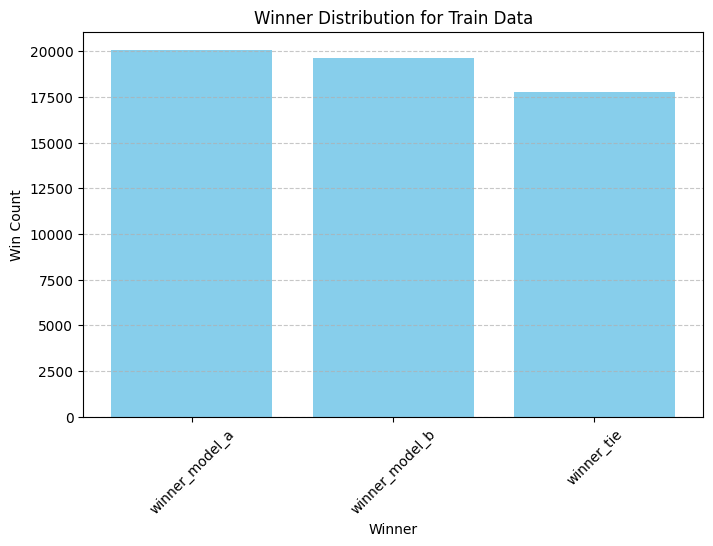

In [15]:
import matplotlib.pyplot as plt

counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

plt.figure(figsize=(8, 5))
plt.bar(counts['Winner'], counts['Win Count'], color='skyblue')
plt.title('Winner Distribution for Train Data')
plt.xlabel('Winner')
plt.ylabel('Win Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




# 🔪 | Data Split

In the code snippet provided below, we will divide the existing data into training and validation using a stratification of `class_label` column.

In [16]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")

print(train_df["class_name"].value_counts(normalize=True))
print(valid_df["class_name"].value_counts(normalize=True))


Train set size: 45981
Validation set size: 11496
class_name
winner_model_a    0.349079
winner_model_b    0.341902
winner_tie        0.309019
Name: proportion, dtype: float64
class_name
winner_model_a    0.349078
winner_model_b    0.341945
winner_tie        0.308977
Name: proportion, dtype: float64


# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [17]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

# Check how many tokens the tokenizer is producing before padding/truncation
def check_token_length(text_pair):
    encoded = preprocessor(text_pair)
    print(f"Tokens shape: {encoded['token_ids'].shape}")
    print(f"First token IDs: {encoded['token_ids'][0][:20]}")  # First 20 tokens of first option

check_token_length(df.options.iloc[0])


token_ids : (2, 256)
padding_mask : (2, 256)
Tokens shape: (2, 256)
First token IDs: [    1 31751   294   273   268   278 21090   423   264   687   264   286
   266   991  3623   265  9661   277 23594  3129]


In [18]:
def preprocess_fn(text, label=None):
    encoded = preprocessor(text)  # Preprocess list of options (expects list/array of 2)
    if label is not None:
        return (encoded, tf.cast(label, tf.int32))
    else:
        return encoded


# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [19]:
#modified version -- for safety
def build_dataset(texts, labels=None, batch_size=32, cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE

    # Convert lists of options into tensor slices (list of lists)
    slices = (texts,) if labels is None else (texts, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)

    if cache:
        ds = ds.cache()

    # Apply preprocessing
    if labels is not None:
        ds = ds.map(lambda x, y: preprocess_fn(x, y), num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda x: preprocess_fn(x), num_parallel_calls=AUTO)

    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        options = tf.data.Options()
        options.experimental_deterministic = False
        ds = ds.with_options(options)

    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTO)

    return ds


## Build Train/Valid Dataloader

In [20]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_ds = build_dataset(train_texts, train_labels,
                         batch_size=CFG.batch_size,
                         shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_ds = build_dataset(valid_texts, valid_labels,
                         batch_size=CFG.batch_size,
                         shuffle=False)

# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [21]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False, verbose=False):
    lr_start = 1.0e-6
    lr_max = 0.6e-6 * batch_size  # linear scaling
    lr_min = 1e-6
    lr_ramp_ep = 2
    lr_sus_ep = 0
    lr_decay = 0.8

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep
            decay_epoch_index = min(epoch - lr_ramp_ep - lr_sus_ep, decay_total_epochs)
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            raise ValueError(f"Unsupported mode: {mode}")
        
        if verbose:
            print(f"Epoch {epoch}: lr = {lr:.8f}")
        return lr

    if plot:
        lrs = [lrfn(e) for e in range(epochs)]
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), lrs, marker='o')
        plt.title(f"Learning Rate Schedule ({mode} decay)")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)


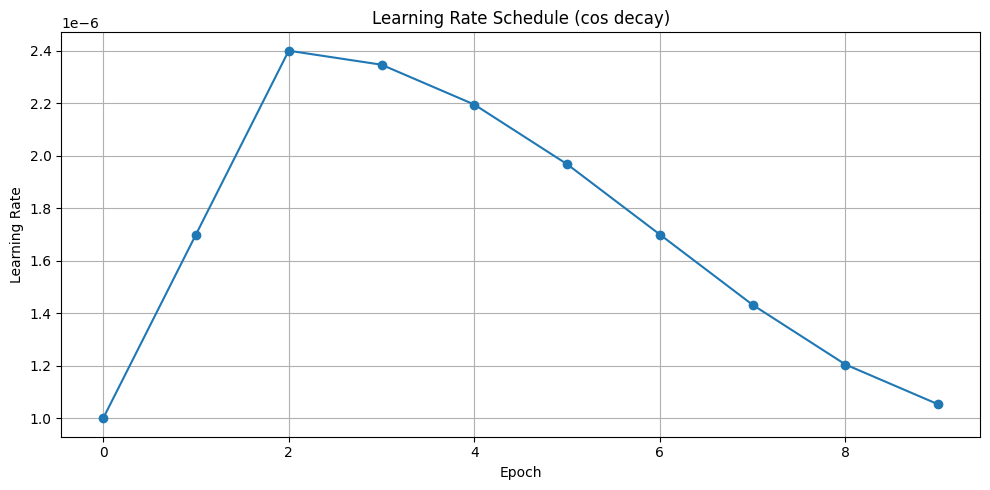

In [22]:
import math
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# 💾 | Model Checkpointing

The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission.

In [23]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

# 📏 | Metric

The metric for this competition is **Log Loss**. This metric can be expressed mathematically as,

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

where $ N $ is the number of samples, $ y_i $ is the true label, and $ p_i $ is the predicted probability of the sample belonging to the positive class.

Note that this metric is similar to categorical cross entropy widely used in classification tasks. Thus, we don't need to implement the loss from scratch. As the Keras library already has an implementation of this metric, we will simply use the metric to monitor performance of our model.


In [24]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

# 🤖 | Modeling

The `KerasNLP` library provides various NLP model architectures such as `Bert`, `Roberta`, `DebertaV3`, and more. While this notebook focuses on `DebertaV3`, you can explore others in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). For a deeper understanding, refer to the [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

The approach utilizes `keras_nlp.models.DebertaV3Classifier` to process each prompt and response pair, generating output embeddings. We then concatenate these embeddings and pass them through a Pooling layer and a classifier to obtain logits, followed by a `softmax` function for the final output.

When dealing with multiple responses, we use a weight-sharing strategy. This means we provide the model with one response at a time along with the prompt `(P + R_A)`, `(P + R_B)`, etc., using the same model weights for all responses. After obtaining embeddings for all responses, we concatenate them and apply average pooling. Next, we use a `Linear/Dense` layer along with the `Softmax` function as the classifier for the final result. Providing all responses at once would increase text length and complicate model handling. Note that, in the classifier, we use 3 classes for `winner_model_a`, `winner_model_b`, and `draw` cases.

The diagram below illustrates this approach:

<div align="center">
    <img src="https://i.postimg.cc/g0gcvy3f/Kaggle-drawio.png">
</div>

From a coding perspective, note that we use the same model for all responses with shared weights, contrary to the separate models implied in the diagram.

In [25]:
from tensorflow import keras
import keras_nlp


inputs = {
    "token_ids": keras.Input(shape=(2, CFG.sequence_length), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, CFG.sequence_length), dtype=tf.int32, name="padding_mask"),
}

# Load DeBERTaV3 backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(CFG.preset)

# Process first response (index 0)
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
features_a = backbone(response_a)  # shape: (batch, seq_len, hidden_dim)
pooled_a = keras.layers.GlobalAveragePooling1D()(features_a)

response_b = {k: v[:, 1, :] for k, v in inputs.items()}
features_b = backbone(response_b)
pooled_b = keras.layers.GlobalAveragePooling1D()(features_b)

concatenated = keras.layers.Concatenate()([pooled_a, pooled_b])

# Normalize + Dropout
x = keras.layers.LayerNormalization()(concatenated)
x = keras.layers.Dropout(0.2)(x)

# Classification head
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(x)

# Build and compile model
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalCrossentropy(name="log_loss"),
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
)



### Model Summary

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, 256)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, 256)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256)       │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256)       │          0 │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 256)       │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256)       │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, 256, 384)  │ 70,682,112 │ get_item_1[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item[0][0],   │
│                     │                   │            │ get_item_3[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ deberta_v3_backb… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ deberta_v3_backb… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 768)       │      1,536 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 768)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,685,955 (269.65 MB)

 Trainable params: 70,685,955 (269.65 MB)

 Non-trainable params: 0 (0.00 B)

# 🚂 | Training

In [ ]:
# Learning Rate Scheduler Callback
lr_cb = get_lr_callback(
    batch_size=CFG.batch_size,
    mode='cos',
    epochs=CFG.epochs,
    plot=False
)

# Model Checkpoint Callback
ckpt_cb = keras.callbacks.ModelCheckpoint(
    'best_model.weights.h5',
    monitor='val_log_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Early Stopping Callback
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_log_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# List of callbacks
callbacks = [lr_cb, ckpt_cb, earlystop_cb]

# Enable full training
print("🚀 Starting full fine-tuning with unfrozen backbone...")
backbone.trainable = True

import time
start = time.time()

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=callbacks
)

print(f"Training complete! Total time: {time.time() - start:.2f}s")



🚀 Starting full fine-tuning with unfrozen backbone...
Epoch 1/10
11496/11496 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3637 - log_loss: 1.2766 - loss: 1.2767
Epoch 1: val_log_loss improved from inf to 1.06333, saving model to best_model.weights.h5
11496/11496 ━━━━━━━━━━━━━━━━━━━━ 1601s 137ms/step - accuracy: 0.3637 - log_loss: 1.2766 - loss: 1.2767 - val_accuracy: 0.4362 - val_log_loss: 1.0633 - val_loss: 1.0634 - learning_rate: 1.0000e-06
Epoch 2/10
11496/11496 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3885 - log_loss: 1.1879 - loss: 1.1880
Epoch 2: val_log_loss improved from 1.06333 to 1.05128, saving model to best_model.weights.h5
11496/11496 ━━━━━━━━━━━━━━━━━━━━ 1537s 132ms/step - accuracy: 0.3885 - log_loss: 1.1879 - loss: 1.1880 - val_accuracy: 0.4497 - val_log_loss: 1.0513 - val_loss: 1.0514 - learning_rate: 1.7000e-06
Epoch 3/10
11496/11496 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4060 - log_loss: 1.1414 - loss: 1.1415
Epoch 3: val_log_loss improved from 1

## Load Best Model

After training, let's load the weight with best result to get the best performance.

In [ ]:
model.load_weights('/kaggle/working/best_model.weights.h5')

# 🧪 | Prediction

In [ ]:
# Build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(test_texts,
                         batch_size=min(len(test_df), CFG.batch_size),
                         shuffle=False)

In [ ]:
# Make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

# 📬 | Submission

Following code will prepare the submission file.

In [ ]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

# 📌 | Reference

* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [AES 2.0: KerasNLP Starter](https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter)